In [1]:
from functools import partial
from typing import NamedTuple

import jax
from jax import numpy as jnp, random as jr
import haiku as hk
import optax

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
class Batch(NamedTuple):
    x: np.ndarray
    y: np.ndarray


## Two spirals dataset

In [3]:
def make_spirals(n_samples, noise_std=0.0, rotations=1.0):
    ts = jnp.linspace(0, 1, n_samples)
    rs = ts**0.5
    thetas = rs * rotations * 2 * jnp.pi
    signs = np.random.randint(0, 2, (n_samples,)) * 2 - 1
    labels = (signs > 0).astype(int)

    xs = rs * signs * jnp.cos(thetas) + np.random.randn(n_samples) * noise_std
    ys = rs * signs * jnp.sin(thetas) + np.random.randn(n_samples) * noise_std
    points = jnp.stack([xs, ys], axis=1)
    return points, labels


2023-08-08 17:02:27.708618: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


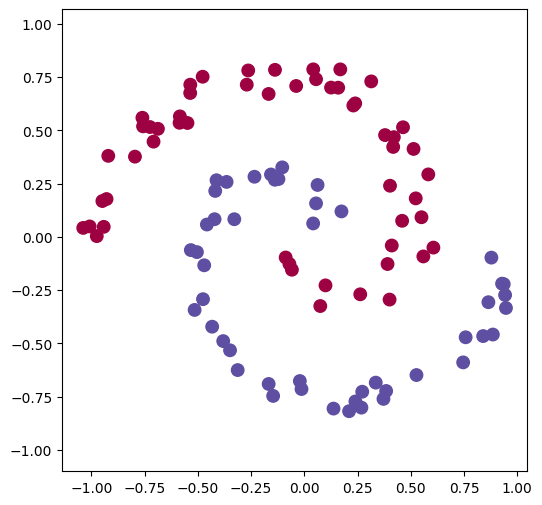

In [4]:
points, labels = make_spirals(100, noise_std=0.05)
df = pd.DataFrame({"x": points[:, 0], "y": points[:, 1], "label": labels})

plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap="Spectral", s=80)
plt.axis("equal")
plt.show()


## A simple classifier

In [5]:
def fwd(x):
    return hk.Sequential(
        [
            hk.Linear(512),
            jax.nn.relu,
            hk.Linear(512),
            jax.nn.relu,
            hk.Linear(2),
            jax.nn.log_softmax,
        ]
    )(x)


network = hk.without_apply_rng(hk.transform(fwd))


### Helper functions for initializing and training

In [6]:
def cross_entropy(logprobs: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
    one_hot_labels = jax.nn.one_hot(labels, logprobs.shape[1])
    return -jnp.mean(jnp.sum(one_hot_labels * logprobs, axis=-1))


def loss_fn(params: hk.Params, batch: Batch) -> jnp.ndarray:
    logits = network.apply(params, batch[0])
    loss = jnp.mean(cross_entropy(logits, batch[1]))
    return loss


loss_and_grad_fn = jax.value_and_grad(loss_fn)


### API for the classifier

In [7]:
class TrainingState(NamedTuple):
    params: hk.Params
    opt_state: optax.OptState
    loss: float


def init(seed: int, optimiser: optax.GradientTransformation) -> TrainingState:
    rng = jr.PRNGKey(jnp.array(seed, int))
    initial_params = network.init(rng, points)
    initial_opt_state = optimiser.init(initial_params)
    return TrainingState(initial_params, initial_opt_state, 0.0)


@partial(jax.jit, static_argnums=(1,))
def update(
    state: TrainingState,
    optimiser: optax.GradientTransformation,
    batch: Batch,
) -> TrainingState:
    loss, grads = loss_and_grad_fn(state.params, batch)
    updates, opt_state = optimiser.update(grads, state.opt_state)
    params = optax.apply_updates(state.params, updates)
    return TrainingState(params, opt_state, loss)


@jax.jit
def predict(params: hk.Params, x: jnp.ndarray) -> jnp.ndarray:
    logits = network.apply(params, x)
    return jnp.argmax(logits, axis=-1)


### Running the network

In [8]:
optimiser = optax.adam(1e-3)
state = init(0, optimiser)
for i in range(100):
    state: TrainingState = update(state, optimiser, (points, labels))

print("Final Loss:", state.loss)

Final Loss: 0.0148204155


In [9]:
def all_preds(state: TrainingState):
    grid_size = 50
    width = 1.5
    x0s, x1s = jnp.meshgrid(
        jnp.linspace(-width, width, grid_size), jnp.linspace(-width, width, grid_size)
    )
    xs = jnp.stack([x0s, x1s]).transpose().reshape((-1, 2))
    preds = predict(state.params, xs)
    return xs, preds


xs, preds = all_preds(state)


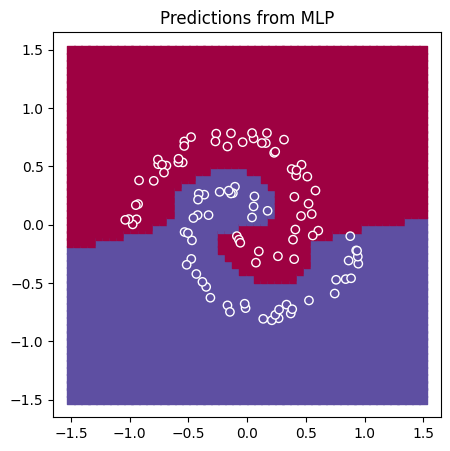

In [10]:
data = {"x": xs[:, 0], "y": xs[:, 1], "pred": preds}

plt.figure(figsize=(5, 5))
plt.scatter(xs[:, 0], xs[:, 1], c=preds, marker="s", cmap="Spectral")
plt.scatter(
    points[:, 0], points[:, 1], c=labels, marker="o", cmap="Spectral", edgecolors="w"
)
plt.title("Predictions from MLP")
plt.show()


## Parallelizing training

In [11]:
parallel_init_fn = jax.vmap(init, in_axes=(0, None))
parallel_train_step_fn = jax.vmap(update, in_axes=(0, None, None))

N = 4
seeds = jnp.linspace(0, N - 1, N)

state = parallel_init_fn(seeds, optimiser)
for i in range(100):
    state = parallel_train_step_fn(state, optimiser, (points, labels))
    
print(state.loss)

[0.01482042 0.01189985 0.01656742 0.01171253]


### Plotting each network's predictions

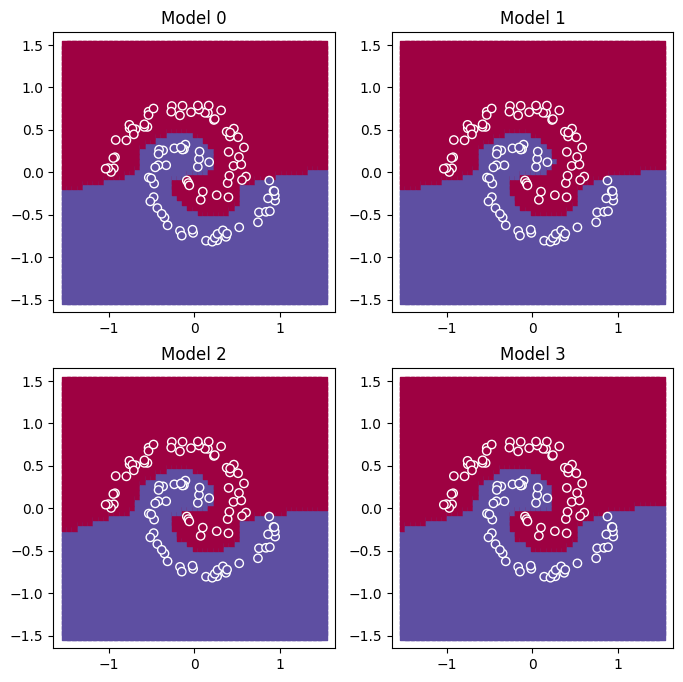

In [12]:
parallel_all_preds = jax.vmap(all_preds)
grid, preds = parallel_all_preds(state)
grid = grid[0]

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
for i, pred in enumerate(preds):
    axs[i // 2, i % 2].scatter(grid[:, 0], grid[:, 1], c=pred, cmap="Spectral", marker="s")
    axs[i // 2, i % 2].scatter(
        points[:, 0],
        points[:, 1],
        c=labels,
        marker="o",
        cmap="Spectral",
        edgecolors="w",
    )
    axs[i // 2, i % 2].set_title(f"Model {i}")
